# Image Segmentation Pipeline

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from sklearn.cluster import KMeans
from toolz import pipe

### Function Definitions

Function to read image from a file in RGB format

In [43]:
def readImage(file):
    image = cv2.imread(file)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

This is just a utility function to print the resulting images of every step of the process (e.g. K Means, Components, etc)

In [56]:
def displayImage(image, title = "Image", cmap = None):
    plt.figure(figsize = (8, 8))
    plt.imshow(image, cmap = cmap) if cmap else plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

    return image

Function to perform the K Means segmentation of the image

**NOTE.** It is not a manual implementation, uses the _scikit-learn_ library

In [45]:
def kMeansSegmentation(image, k = 3):
    # Reshape the image into a 2D array of pixels
    pixels = image.reshape((-1, 3))
    
    # Apply KMeans using scikit-learn
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pixels)
    centroids = kmeans.cluster_centers_
    
    # Assign each pixel to the nearest centroid
    segmentedImage = centroids[labels].reshape(image.shape).astype(np.uint8)
    
    displayImage(segmentedImage, "K-means Segmentation")
    
    # Reshape labels to match the original image dimensions
    segmentedImage = labels.reshape(image.shape[:2])
    return segmentedImage

Function to extract connected components

In [46]:
def extractConnectedComponents(segmentedImage, minArea = 500):
    height, width = segmentedImage.shape
    labeledImage = np.zeros_like(segmentedImage, dtype = np.int32)
    currentLabel = 1
    
    # Label connected components using a stack
    def floodFill(x, y, label):
        stack = [(x, y)]
        componentPixels = []
        
        while stack:
            cx, cy = stack.pop()
            if labeledImage[cx, cy] == 0 and segmentedImage[cx, cy] == segmentedImage[x, y]:
                labeledImage[cx, cy] = label
                componentPixels.append((cx, cy))
                
                # Check neighbors
                for nx, ny in [(cx + 1, cy), (cx - 1, cy), (cx, cy + 1), (cx, cy - 1)]:
                    if (0 <= nx and nx < height) and (0 <= ny and ny < width) and labeledImage[nx, ny] == 0:
                        stack.append((nx, ny))
        
        return componentPixels
    
    for i in range(height):
        for j in range(width):
            if labeledImage[i, j] == 0:
                componentPixels = floodFill(i, j, currentLabel)
                
                # Check the area of the component, if it's too small, don't take it into account
                # This is necessary for the program to avoid considering really small components (which are a lot)
                if len(componentPixels) >= minArea:
                    currentLabel += 1
                else:
                    for x, y in componentPixels:
                        labeledImage[x, y] = 0
    
    displayImage(labeledImage, "Connected Components After Filtering", cmap="jet")
    return labeledImage, currentLabel - 1

In [47]:
def computeFeatures(labeledImage, originalImage, numLabels):
    for component in range(1, numLabels + 1):
        # Extract mask for the current component
        mask = (labeledImage == component)
        componentPixels = originalImage[mask]

        # Compute area
        area = np.sum(mask)
        
        # Compute perimeter
        # This is done by checking border pixels
        perimeter = 0
        height, width = mask.shape
        for x in range(height):
            for y in range(width):
                if mask[x, y]:
                    # Check if this pixel has any background neighbors
                    neighbors = [
                        (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),
                        (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)
                    ]
                    if any(0 <= nx < height and 0 <= ny < width and not mask[nx, ny] for nx, ny in neighbors):
                        perimeter += 1

        # Compute Hu moments (descriptors of the image)
        moments = cv2.moments(mask.astype(np.uint8))
        huMoments = cv2.HuMoments(moments).flatten()
        
        # Calculate mean and variance for each color channel
        meanColor = np.mean(componentPixels, axis=0)
        varColor = np.var(componentPixels, axis=0)
        
        # Display the results for each component
        print("Component:", component)
        print("Area:", area)
        print("Perimeter:", perimeter)
        print("Hu Moments:", huMoments)
        print("Mean per Color:", meanColor)
        print("Variance per Color:", varColor)
        displayImage(mask.astype(np.uint8) * 255, f"Component {component}")

### Pipeline

Definition of the pipeline

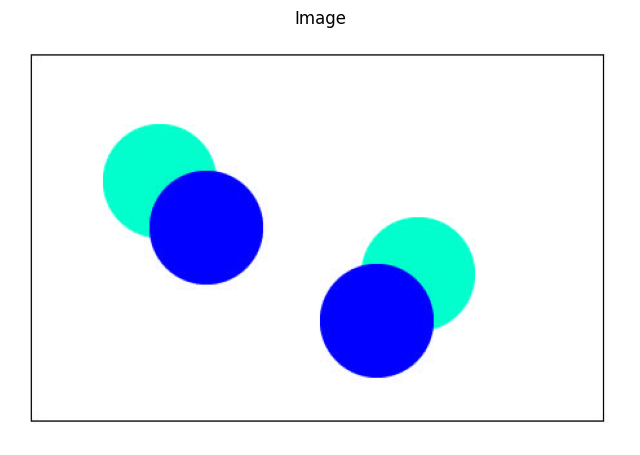

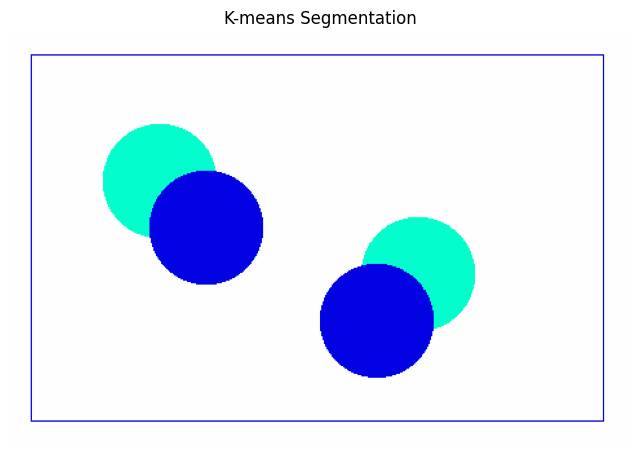

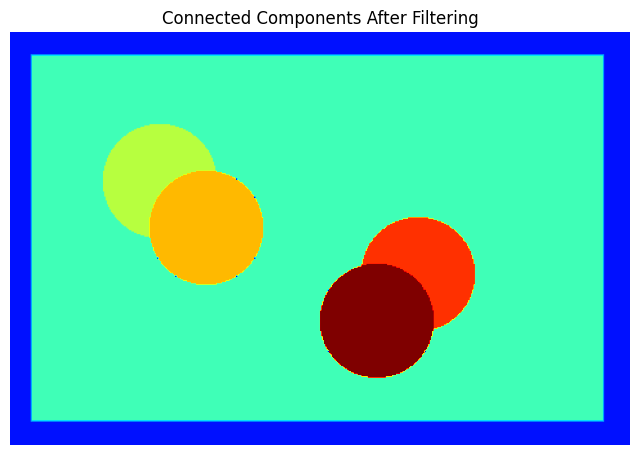

TypeError: computeFeatures() missing 2 required positional arguments: 'originalImage' and 'numLabels'

In [57]:
segmentationPipe = pipe(
    "testImg5.jpg",
    readImage,
    displayImage,
    kMeansSegmentation,
    extractConnectedComponents,
    computeFeatures
)

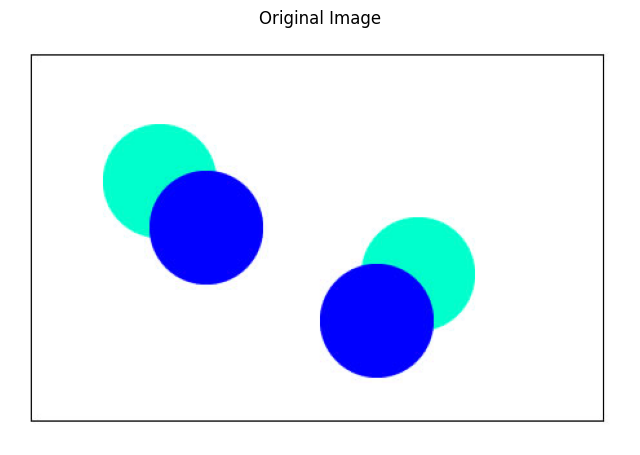

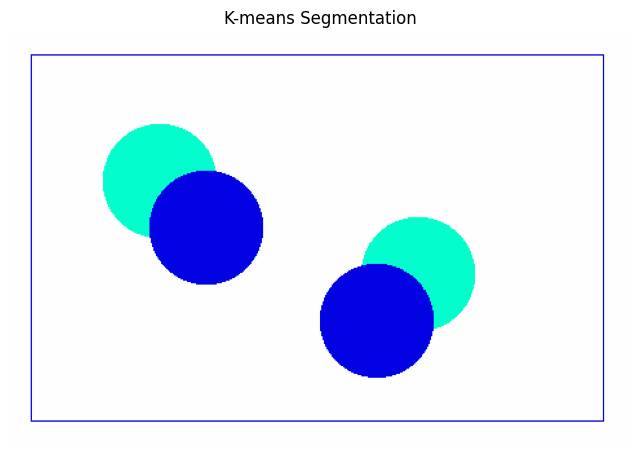

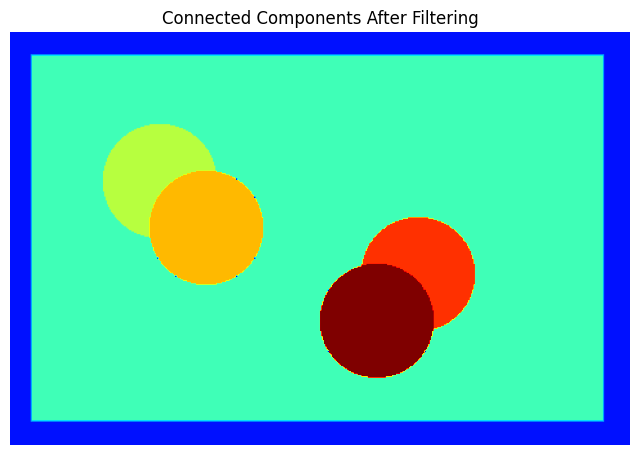

Component: 1
Area: 27504
Perimeter: 1460
Hu Moments: [1.76871554e+00 2.96067856e-01 1.01602311e-03 1.28240697e-02
 4.62903643e-05 6.97784792e-03 1.16384248e-18]
Mean per Color: [254.87449098 254.87449098 254.87449098]
Variance per Color: [0.41109449 0.41109449 0.41109449]


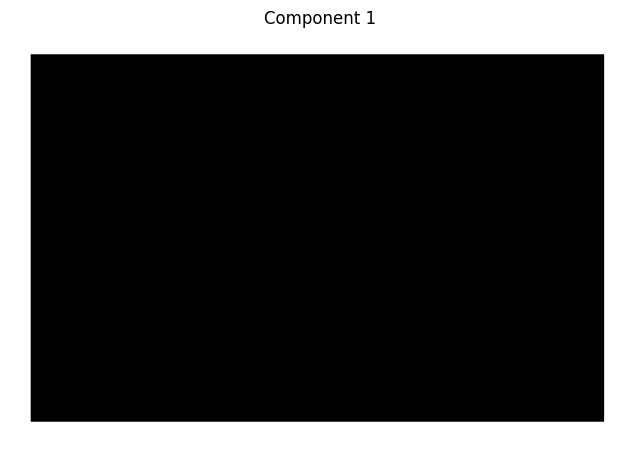

Component: 2
Area: 1452
Perimeter: 1452
Hu Moments: [30.25011478 96.78871947  0.          0.          0.          0.
  0.        ]
Mean per Color: [3.90633609 3.90633609 3.90633609]
Variance per Color: [4.1399874 4.1399874 4.1399874]


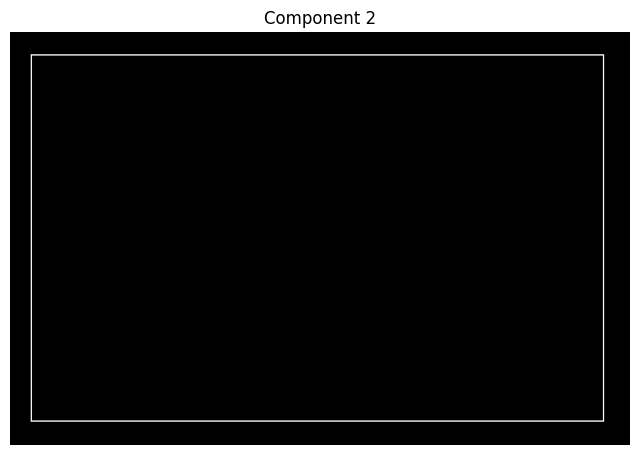

Component: 3
Area: 104069
Perimeter: 2436
Hu Moments: [2.43315513e-01 1.00455356e-02 2.19561594e-05 2.98303770e-05
 7.47176099e-10 1.79896674e-06 1.56669718e-10]
Mean per Color: [254.85747917 254.81345069 254.64397659]
Variance per Color: [ 1.29341236  6.63761862 16.21735557]


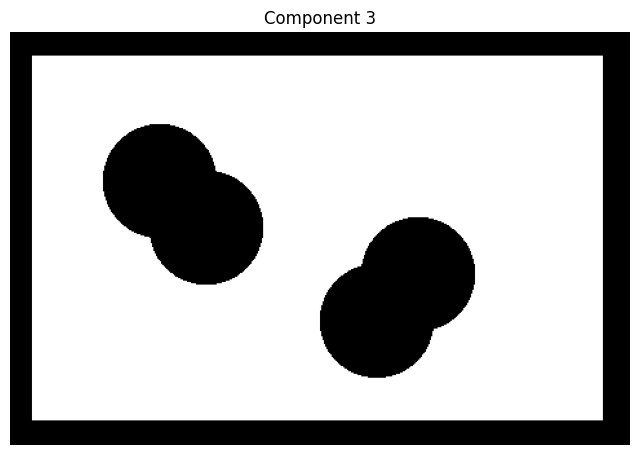

Component: 4
Area: 4242
Perimeter: 344
Hu Moments: [ 1.96578464e-01  6.23021956e-03  1.51362606e-03  1.41734074e-04
 -6.56478795e-08 -1.11873170e-05  0.00000000e+00]
Mean per Color: [205.51461575 254.09193777   3.57920792]
Variance per Color: [ 18.12814564  33.88735131 190.16357523]


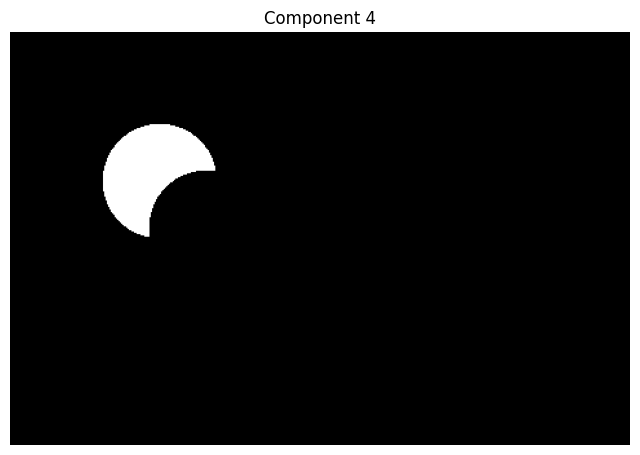

Component: 5
Area: 6142
Perimeter: 348
Hu Moments: [1.59150877e-01 8.72530025e-09 2.08471372e-09 7.24313653e-15
 2.81457755e-26 6.76576427e-19 0.00000000e+00]
Mean per Color: [253.00179095   2.36763269   2.07147509]
Variance per Color: [ 12.25154352 151.76422751 126.85991899]


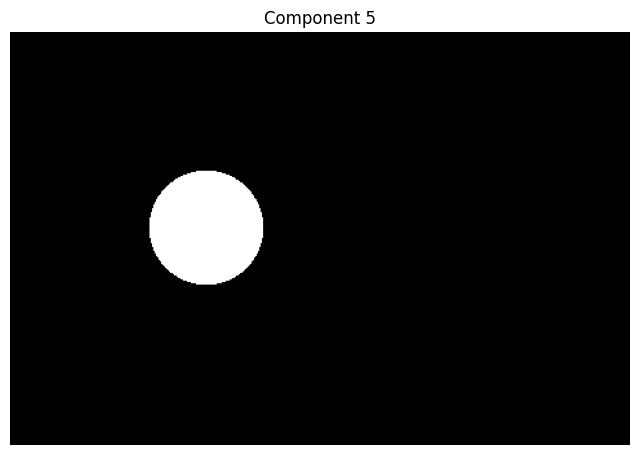

Component: 6
Area: 4045
Perimeter: 345
Hu Moments: [ 2.04025838e-01  7.77682855e-03  1.93526419e-03  1.97062180e-04
 -1.21692639e-07 -1.73780334e-05 -8.56024630e-10]
Mean per Color: [205.59826947 254.03312732   3.58640297]
Variance per Color: [ 16.2309488   42.4636739  195.44698447]


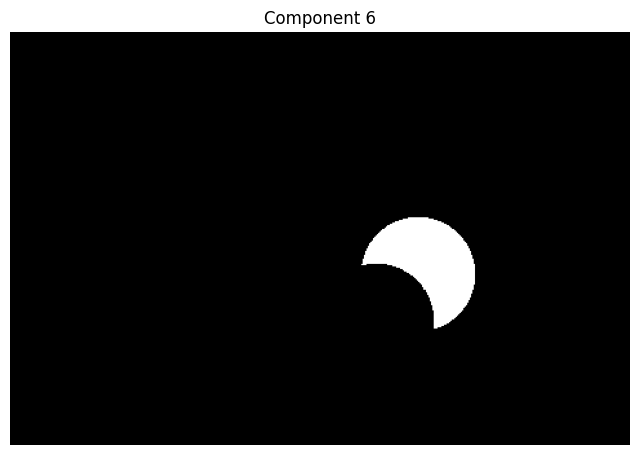

Component: 7
Area: 6137
Perimeter: 348
Hu Moments: [ 1.59151922e-01  1.83321409e-08  3.36551169e-09  1.97079368e-13
 -3.62373711e-24  8.39465615e-18  3.55390395e-24]
Mean per Color: [253.02020531   2.27146814   1.98598664]
Variance per Color: [ 14.35676952 148.30205867 122.49678912]


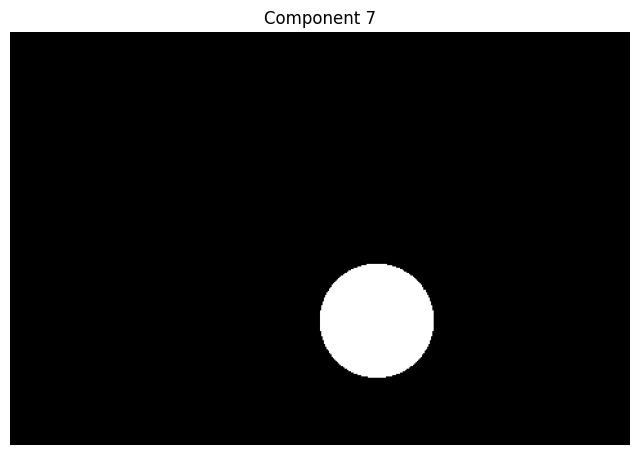

In [48]:
# Load image
image_path = "testImg5.jpg"
original_image = readImage(image_path)
displayImage(original_image, "Original Image")

# Perform unsupervised segmentation using K-means from scikit-learn
segmented_image = kMeansSegmentation(original_image, k=3)

# Extract connected components with filtering for small areas
labeled_image, num_labels = extractConnectedComponents(segmented_image, minArea=500)

# Compute features for each component
computeFeatures(labeled_image, original_image, num_labels)